In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# from scipy import stats

from utils import (
    detrend, monthly_anomalies,reg_slope,
    standardize, corr_with_ttest
)

In [2]:
eq = dict(lat=0,lon=slice(140,260))

timea = slice('1958-01','2019-11')
timeb = slice('1993-01','2019-11')

In [3]:
t_grid_file = xr.open_zarr('data/ORCA025.L46-KFS006_TroPA.zarr')

In [4]:
def nlti(ssh,d20):
    slope = reg_slope(d20, ssh, dim="time")

    sshmd20 = (
        ssh - slope * d20
    ).rename("NLTI")

    nlti=detrend(
        sshmd20
    )
    return nlti

### 1. Prepare data
#### 1.1 SSH 

In [5]:
ssh_o = t_grid_file.sossheig.sel(**eq)
ssh_o.attrs["units"] = "m"
ssh_a = monthly_anomalies(ssh_o.sel(time=timea))
ssh_b = monthly_anomalies(ssh_o.sel(time=timeb))

#### 1.2 D20 

In [6]:
d20_o = -1 * t_grid_file.d20.sel(**eq)

In [7]:
d20_a = monthly_anomalies(d20_o.sel(time=timea))
d20_b = monthly_anomalies(d20_o.sel(time=timeb))

#### 1.3 linear data (NEMO fitting) 

In [8]:
eta = (
    xr.open_zarr("data/lmmm_eta_nemo.zarr/")
    .eta
    .interp(lat=0)
    .sel(lon=slice(140,260))
    .sel(mode=slice(1, 3))
)

In [9]:
eta_a = eta.assign_coords(
    {'time':(eta.time-np.timedelta64(1314900,'s')).data}
).interp(time=ssh_a.time).fillna(0.)

In [10]:
eta_b = eta_a.sel(time = timeb)

#### 1.4 fitting (to NEMO)

In [11]:
def fitting(ssha,eta_x):
    mask = ~(
        np.isnan(ssha).all('time')
        | np.isnan(eta_x.sel(mode=1)).all('time')
    )
    a = np.vstack(
        [
            eta_x.sel(mode=k)[:, mask].values.flatten()
            for k in (1,2,3)
        ]
    ).T
    a_inv = np.linalg.pinv(a)

    b = ssha[:, mask].values.flatten()

    coeff = a_inv.dot(b)
    coeff = xr.DataArray(
        coeff,
        coords=(eta_x.sel(mode=slice(1, 3)).mode,),
        dims=("mode",)
    )
    return coeff

In [12]:
coeff_a = fitting(ssh_a, eta_a)
coeff_b = fitting(ssh_b, eta_b)

In [13]:
sshli_a = (coeff_a * eta_a).sum("mode").compute()
sshli_b = (coeff_b * eta_b).sum("mode").compute()

#### 1.5 Fitting to AVISO 

In [14]:
eta_aviso = (
    xr.open_zarr("data/lmmm_eta_woa13.zarr/")
    .eta
    .interp(lat=0)
    .sel(lon=slice(140,260))
    .sel(mode=slice(1, 3))
)

In [15]:
sla = xr.open_dataset(
    'data/aviso199301_202002.nc'
).sla.interp(lat=0., lon=eta.lon).fillna(0.)

In [16]:
ssh_d = monthly_anomalies(sla.sel(time=timeb))

In [17]:
eta_d = eta_aviso.assign_coords(
    {'time':(eta.time-np.timedelta64(1314900,'s')).data}
).interp(time=ssh_b.time).fillna(0.)

In [18]:
coeff_d = fitting(ssh_d, eta_d)

In [19]:
sshli_d = (coeff_d * eta_d).sum("mode")

### 2. Fig4a: Correlation

In [20]:
dseta = xr.Dataset({"sshne": ssh_a, "sshli": sshli_a, "d20ne": d20_a.fillna(0.)})
dseta_dt = detrend(dseta.compute())

In [21]:
corr_ssha_sshlia, corr_ssha_sshlia_low, corr_ssha_sshlia_up = corr_with_ttest(dseta_dt.sshne, dseta_dt.sshli, sig=0.95)
corr_d20a_sshlia, corr_d20a_sshlia_low, corr_d20a_sshlia_up = corr_with_ttest((-1)*dseta_dt.d20ne, dseta_dt.sshli, sig=0.95)

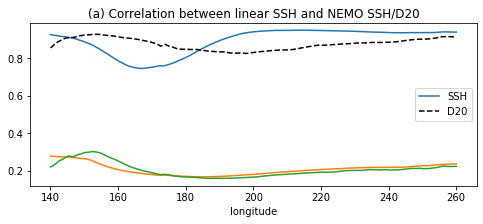

In [22]:
fig = plt.figure(figsize=(8,3))
corr_ssha_sshlia.plot(label='SSH')
corr_d20a_sshlia.plot(label='D20',color='black', linestyle='--')
corr_ssha_sshlia_up.plot()
corr_d20a_sshlia_up.plot()
plt.title('(a) Correlation between linear SSH and NEMO SSH/D20')
plt.xlabel('longitude');
plt.legend()

### 3. Fig4bcd: Create NLTIs and test for FigS4

In [23]:
ssh_b = detrend(ssh_b.compute())
d20_b = detrend(d20_b.compute())
d20_c = -1*detrend(sshli_b.compute())
ssh_d = detrend(ssh_d.compute())
d20_d = -1*detrend(sshli_d.compute())

In [24]:
nlti_nemo = nlti(ssh_b,d20_b)
nlti_nemolin = nlti(ssh_b,d20_c)
nlti_aviso = nlti(ssh_d,d20_d)

In [25]:
corr_nlti_nemo_nlti_nemolin, corr_nlti_nemo_nlti_nemolin_up, corr_nlti_nemo_nlti_nemolin_low = corr_with_ttest(nlti_nemo, nlti_nemolin, sig=0.95)
corr_nlti_nemolin_nlti_aviso, corr_nlti_nemolin_nlti_aviso_up, corr_nlti_nemolin_nlti_aviso_low = corr_with_ttest(nlti_nemolin, nlti_aviso, sig=0.95)
corr_nlti_aviso_nlti_nemo, corr_nlti_aviso_nlti_nemo_up, corr_nlti_aviso_nlti_nemo_low = corr_with_ttest(nlti_aviso, nlti_nemo, sig=0.95)

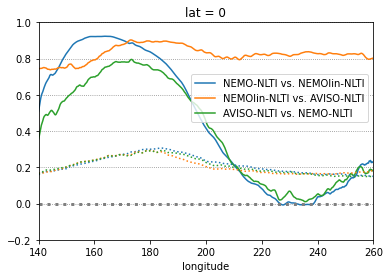

In [26]:
corr_nlti_nemo_nlti_nemolin.plot(label='NEMO-NLTI vs. NEMOlin-NLTI')
corr_nlti_nemolin_nlti_aviso.plot(label='NEMOlin-NLTI vs. AVISO-NLTI')
corr_nlti_aviso_nlti_nemo.plot(label='AVISO-NLTI vs. NEMO-NLTI')
corr_nlti_nemo_nlti_nemolin_up.plot(c='C0', ls=":")
corr_nlti_nemolin_nlti_aviso_up.plot(c='C1', ls=":")
corr_nlti_aviso_nlti_nemo_up.plot(c='C2', ls=":")

plt.legend(loc=7,bbox_to_anchor=(1, 0.65))
plt.ylim(-0.2,1)
plt.xlim(140,260)
plt.ylabel("");
plt.xlabel('longitude');
plt.axhline(y=0., c="0.5", ls=":", lw=3)
plt.grid(color='grey',linestyle = ':',axis='y')

## Write output

In [27]:
!rm -rf data_fig4.zarr
xr.Dataset(
    dict(
        corr_ssha_sshlia=corr_ssha_sshlia,
        corr_d20a_sshlia=corr_d20a_sshlia,
        corr_ssha_sshlia_up=corr_ssha_sshlia_up,
        corr_d20a_sshlia_up=corr_d20a_sshlia_up,
        corr_ssha_sshlia_low=corr_ssha_sshlia_low,
        corr_d20a_sshlia_low=corr_d20a_sshlia_low,
        nlti_nemo=nlti_nemo,
        nlti_nemolin=nlti_nemolin,
        nlti_aviso=nlti_aviso
    )
).to_zarr("data_fig4.zarr");

In [29]:
!rm -rf data_figS5.zarr
xr.Dataset(
    dict(
        nlti_nemo_var=nlti_nemo.var("time", ddof=1),
        nlti_nemolin_var=nlti_nemolin.var("time", ddof=1),
        nlti_aviso_var=nlti_aviso.var("time", ddof=1),
        corr_nlti_nemo_nlti_nemolin=corr_nlti_nemo_nlti_nemolin,
        corr_nlti_nemolin_nlti_aviso=corr_nlti_nemolin_nlti_aviso,
        corr_nlti_aviso_nlti_nemo=corr_nlti_aviso_nlti_nemo,
    )
).to_zarr("data_figS5.zarr");